In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#installations
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
!pip install --quiet einops
!pip install --quiet SimpleITK
!pip install --quiet livelossplot
!pip install --quiet seaborn
!pip install --quiet CTViewer

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 362 (delta 114), reused 74 (delta 74), pack-reused 225
Receiving objects: 100% (362/362), 3.24 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (177/177), done.
     |████████████████████████████████| 52.8 MB 129 kB/s 
     |████████████████████████████████| 1.6 MB 7.3 MB/s 


In [ ]:
#imports
import os
os.chdir(f'./Transformer-Explainability')
import torch
import pandas as pd
import torch.nn as nn
from einops import rearrange
from modules.layers_ours import *
from baselines.ViT.helpers import load_pretrained
from baselines.ViT.weight_init import trunc_normal_
from baselines.ViT.layer_helpers import to_2tuple
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import cv2
import SimpleITK as sitk
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torchvision
from livelossplot import PlotLosses
import scipy
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from baselines.ViT.ViT_explanation_generator import LRP
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from ctviewer import CTViewer
from sklearn.metrics import RocCurveDisplay
import datetime
from datetime import datetime
import json
#1000 patches
#device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [ ]:
#functions
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    # all_layer_matrices = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
    #                       for i in range(len(all_layer_matrices))]
    joint_attention = all_layer_matrices[start_layer]
    for i in range(start_layer+1, len(all_layer_matrices)):
        joint_attention = all_layer_matrices[i].bmm(joint_attention)
    return joint_attention

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Linear(in_features, hidden_features)
        self.act = GELU()
        self.fc2 = Linear(hidden_features, out_features)
        self.drop = Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

    def relprop(self, cam, **kwargs):
        cam = self.drop.relprop(cam, **kwargs)
        cam = self.fc2.relprop(cam, **kwargs)
        cam = self.act.relprop(cam, **kwargs)
        cam = self.fc1.relprop(cam, **kwargs)
        return cam


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False,attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = head_dim ** -0.5

        # A = Q*K^T
        self.matmul1 = einsum('bhid,bhjd->bhij')
        # attn = A*V
        self.matmul2 = einsum('bhij,bhjd->bhid')

        self.qkv = Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Linear(dim, dim)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(dim=-1)

        self.attn_cam = None
        self.attn = None
        self.v = None
        self.v_cam = None
        self.attn_gradients = None

    def get_attn(self):
        return self.attn

    def save_attn(self, attn):
        self.attn = attn

    def save_attn_cam(self, cam):
        self.attn_cam = cam

    def get_attn_cam(self):
        return self.attn_cam

    def get_v(self):
        return self.v

    def save_v(self, v):
        self.v = v

    def save_v_cam(self, cam):
        self.v_cam = cam

    def get_v_cam(self):
        return self.v_cam

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    #this may cause issues for 3d? or does it act upoon the patches

    def forward(self, x):
        b, n, _, h = *x.shape, self.num_heads
        qkv = self.qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        self.save_v(v)

        dots = self.matmul1([q, k]) * self.scale

        attn = self.softmax(dots)
        attn = self.attn_drop(attn)

        self.save_attn(attn)
        attn.register_hook(self.save_attn_gradients)

        out = self.matmul2([attn, v])
        out = rearrange(out, 'b h n d -> b n (h d)')

        out = self.proj(out)
        out = self.proj_drop(out)
        return out

    def relprop(self, cam, **kwargs):
        cam = self.proj_drop.relprop(cam, **kwargs)
        cam = self.proj.relprop(cam, **kwargs)
        cam = rearrange(cam, 'b n (h d) -> b h n d', h=self.num_heads)

        # attn = A*V
        (cam1, cam_v)= self.matmul2.relprop(cam, **kwargs)
        cam1 /= 2
        cam_v /= 2

        self.save_v_cam(cam_v)
        self.save_attn_cam(cam1)

        cam1 = self.attn_drop.relprop(cam1, **kwargs)
        cam1 = self.softmax.relprop(cam1, **kwargs)

        # A = Q*K^T
        (cam_q, cam_k) = self.matmul1.relprop(cam1, **kwargs)
        cam_q /= 2
        cam_k /= 2

        cam_qkv = rearrange([cam_q, cam_k, cam_v], 'qkv b h n d -> b n (qkv h d)', qkv=3, h=self.num_heads)

        return self.qkv.relprop(cam_qkv, **kwargs)


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = LayerNorm(dim, eps=1e-6)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

        self.add1 = Add()
        self.add2 = Add()
        self.clone1 = Clone()
        self.clone2 = Clone()

    def forward(self, x):
        x1, x2 = self.clone1(x, 2)
        x = self.add1([x1, self.attn(self.norm1(x2))])
        x1, x2 = self.clone2(x, 2)
        x = self.add2([x1, self.mlp(self.norm2(x2))])
        return x

    def relprop(self, cam, **kwargs):
        (cam1, cam2) = self.add2.relprop(cam, **kwargs)
        cam2 = self.mlp.relprop(cam2, **kwargs)
        cam2 = self.norm2.relprop(cam2, **kwargs)
        cam = self.clone2.relprop((cam1, cam2), **kwargs)

        (cam1, cam2) = self.add1.relprop(cam, **kwargs)
        cam2 = self.attn.relprop(cam2, **kwargs)
        cam2 = self.norm1.relprop(cam2, **kwargs)
        cam = self.clone1.relprop((cam1, cam2), **kwargs)
        return cam

#3D patch embedder
class PatchEmbed3D(nn.Module):
  """ Image to Patch Embedding
  """
  def __init__(self, img_size = (200, 100, 150), patch_size = (20, 10, 15), in_chans = 1, embed_dim = 768):
    super().__init__()
    img_size = to_2tuple(img_size)
    patch_size = to_2tuple(patch_size)
    num_patches = (img_size[2] // patch_size[2]) * (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
    self.img_size = img_size
    self.patch_size = patch_size
    self.num_patches = num_patches
    self.proj = torch.nn.Conv3d(in_chans, embed_dim, kernel_size = patch_size, stride = patch_size)

  def forward(self, x):
    B, C, H, W, D = x.shape
    # FIXME look at relaxing size constraints
    assert H == self.img_size[0] and W == self.img_size[1] and D == self.img_size[2], \
      f"Input image size ({H}*{W}*{D}) doesn't match model ({self.img_size[0]} * {self.img_size[1]} * {self.img_size[2]})."
    x = self.proj(x).flatten(2).transpose(1, 2)
    return x
    
  def relprop(self, cam, **kwargs):
    cam = cam.transpose(1,2) #why transpose?
    cam = cam.reshape(cam.shape[0], cam.shape[1], cam.reshape[2], #is the cam in 3d as well?
                      (self.img_size[0] // self.patch_size[0]), 
                      (self.img_size[1] // self.patch_size[1]), 
                      (self.img_size[2] // self.patch_size[2])
                      )
    return self.proj.relprop(cam, **kwargs)
  

class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=(200, 100, 150), patch_size=(20, 10, 15), in_chans=1, num_classes=2, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, mlp_head=False, drop_rate=0., attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.patch_embed = PatchEmbed3D(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate)
            for i in range(depth)])

        self.norm = LayerNorm(embed_dim)
        if mlp_head:
            # paper diagram suggests 'MLP head', but results in 4M extra parameters vs paper
            self.head = Mlp(embed_dim, int(embed_dim * mlp_ratio), num_classes)
        else:
            # with a single Linear layer as head, the param count within rounding of paper
            self.head = Linear(embed_dim, num_classes)

        # FIXME not quite sure what the proper weight init is supposed to be,
        # normal / trunc normal w/ std == .02 similar to other Bert like transformers
        trunc_normal_(self.pos_embed, std=.02)  # embeddings same as weights?
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

        self.pool = IndexSelect()
        self.add = Add()

        self.inp_grad = None

    def save_inp_grad(self,grad):
        self.inp_grad = grad

    def get_inp_grad(self):
        return self.inp_grad


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @property
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.add([x, self.pos_embed])

        x.register_hook(self.save_inp_grad)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = self.pool(x, dim=1, indices=torch.tensor(0, device=x.device))
        x = x.squeeze(1)
        x = self.head(x)
        return x

    def relprop(self, cam=None,method="transformer_attribution", is_ablation=False, start_layer=0, **kwargs):
        # print(kwargs)
        # print("conservation 1", cam.sum())
        cam = self.head.relprop(cam, **kwargs)
        cam = cam.unsqueeze(1)
        cam = self.pool.relprop(cam, **kwargs)
        cam = self.norm.relprop(cam, **kwargs)
        for blk in reversed(self.blocks):
            cam = blk.relprop(cam, **kwargs)

        # print("conservation 2", cam.sum())
        # print("min", cam.min())

        if method == "full":
            (cam, _) = self.add.relprop(cam, **kwargs)
            cam = cam[:, 1:]
            cam = self.patch_embed.relprop(cam, **kwargs)
            # sum on channels
            cam = cam.sum(dim=1)
            return cam

        elif method == "rollout":
            # cam rollout
            attn_cams = []
            for blk in self.blocks:
                attn_heads = blk.attn.get_attn_cam().clamp(min=0)
                avg_heads = (attn_heads.sum(dim=1) / attn_heads.shape[1]).detach()
                attn_cams.append(avg_heads)
            cam = compute_rollout_attention(attn_cams, start_layer=start_layer)
            cam = cam[:, 0, 1:]
            return cam
        
        # our method, method name grad is legacy
        elif method == "transformer_attribution" or method == "grad":
            cams = []
            for blk in self.blocks:
                grad = blk.attn.get_attn_gradients()
                cam = blk.attn.get_attn_cam()
                cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
                grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
                cam = grad * cam
                cam = cam.clamp(min=0).mean(dim=0)
                cams.append(cam.unsqueeze(0))
            rollout = compute_rollout_attention(cams, start_layer=start_layer)
            cam = rollout[:, 0, 1:]
            return cam
            
        elif method == "last_layer":
            cam = self.blocks[-1].attn.get_attn_cam()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            if is_ablation:
                grad = self.blocks[-1].attn.get_attn_gradients()
                grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
                cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            cam = cam[0, 1:]
            return cam

        elif method == "last_layer_attn":
            cam = self.blocks[-1].attn.get_attn()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            cam = cam.clamp(min=0).mean(dim=0)
            cam = cam[0, 1:]
            return cam

        elif method == "second_layer":
            cam = self.blocks[1].attn.get_attn_cam()
            cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
            if is_ablation:
                grad = self.blocks[1].attn.get_attn_gradients()
                grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
                cam = grad * cam
            cam = cam.clamp(min=0).mean(dim=0)
            cam = cam[0, 1:]
            return cam


def _conv_filter(state_dict, patch_size=30):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict

def get_files(path):
  dir  = []
  for s in sorted(os.listdir(path)): 
    if s.endswith('.nii') | s.endswith('.nii.gz'):
      dir.append(s)
  dir = sorted(dir)
  return dir

In [ ]:
#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, col_image, col_label, aug = False, shuffle = False):
      #params
      self.df = df
      if shuffle:
        self.df = self.df.sample(frac = 1, random_state = 42,).reset_index()
      self.aug = aug
      self.col_image = col_image
      self.col_label = col_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      #row
      row = self.df.iloc[idx]

      #read image
      image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])), axis = 0))
      label = row[self.col_label]

      #if aug
      if self.aug:
        #augmentation (increase this given size of the data)
        if random.random() > 0.5: #0.7 0.8
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
        if random.random() > 0.5:
          #rotate
          image = torchvision.transforms.functional.rotate(image, 
                                                           random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]))
        #noise
        if random.random() > 0.5:
          noise = torch.normal(random.uniform(-0.9, 0.9), random.uniform(0.01, 0.1), image.shape)
          image = image + noise

        #alternate roations doesn't work due to shape
        #if random.random() > 0.5:
        #  ls = random.sample([1,2,3], 2)
        #  k = random.randint(1, 3)
        #  image = torch.rot90(image, k, ls)

        #affine or perspective may be more aggressive? tranlate and scale --> have to make sure are valid inputs!
        #hopefully increase scale invariance!
        #if random.random() > 0.5:
          #careful not to cut off
          #x = random.choice([5, 10, 15, -5, -10, -15])
          #y = random.choice([5, 10, 15, -5, -10, -15])
          #higher indicates more zoom in (AAA usually in center; may decide to remove if model not fitting correctly)
          #may also remove the perspective aspect of the problem (gauging if bigger or smaller!)
          #scaling = random.choice([0.9, 1.1, 1.5, 1.9])
          #image = torchvision.transforms.functional.affine(image, angle = 0, translate = (x, y), scale = scaling, shear = 0, fill = -1, 
          #interpolation = torchvision.transforms.InterpolationMode.BILINEAR)
      #return
      return image, label

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#load a pretrained model
def load_pretrained_model(save_folder, device):
  train_params = load_params(save_folder + 'train_params.json')
  model = torch.load(train_params['save_path'] + 'model.pth', map_location = device)
  model.to(device)
  return train_params, model

#perform inference
def perform_inference(row, col_image, model, device):
  #image
  image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk.ReadImage(row[col_image])), axis = (0, 1)))
  #infer
  logits = model(image.to(device))
  image = None
  #softmax
  probs = torch.softmax(logits, dim = 1)
  #save the neg class
  neg_prob = probs.detach().cpu().numpy()[0][0]
  #save pos class
  pos_prob = probs.detach().cpu().numpy()[0][1]
  #select the higher prob
  prediction = torch.argmax(probs, dim = 1).detach().cpu().numpy()[0]
  #return
  return neg_prob, pos_prob, prediction

#plot confusion matrix
def plot_confusion_matrix(labels, predictions, title, ticks, train_params, pred_type):
  #cmap
  cm = confusion_matrix(labels, predictions)
  #sub
  ax = plt.subplot()
  sns.set(font_scale=2.0) # Adjust to fit
  sns.heatmap(cm, annot=True, ax=ax, cmap="binary", fmt="g");
  # Labels, title and ticks
  label_font = {'size':'20'}  # Adjust to fit
  ax.set_xlabel('Predictions', fontdict=label_font);
  ax.set_ylabel('Class Labels', fontdict=label_font);

  title_font = {'size':'20'}  # Adjust to fit
  ax.set_title(title, fontdict=title_font);

  ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
  ax.xaxis.set_ticklabels(ticks);
  ax.yaxis.set_ticklabels(ticks);

  #save
  plt.savefig(train_params['save_path'] + pred_type + '_' + title.replace(' Set', '') +'.png', bbox_inches="tight")
  plt.show()

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#visualize one specific image (cannot superimpose mask as of yet)
def visualize_specific_image(row, im_type):
  image = sitk.GetArrayFromImage(sitk.ReadImage(row[im_type]))
  CTViewer(image)
  plt.show()

#get optimal
def get_opt(df, train_params, cutoffs, data):
  #get specific
  df_data = df[df['DATA'] == data]
  #get probs for positive class
  probs = df_data['Pos-Prob'].to_numpy()
  #get labels
  labels = df_data['Class_Label'].to_numpy()
  #init
  metrics = []
  #set the thresholds
  for cutoff in cutoffs:
    #get predictions based on cutoff
    predictions = np.where(probs > cutoff, 1, 0)
    #get the confusion matrix based on the cutoff
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    #calculate precision
    precision = tp/(tp+fp)
    #calculate negative predictive value
    neg_pred_value = tn/(tn+fn)
    #get the recall or sensitivity (binary)
    recall = tp/(tp+fn)
    #get the specificity
    specificity = tn/(tn+fp)
    #get the f1 score
    f1 = (2*precision*recall)/(precision + recall)
    #get the accuracy
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    #append
    #collect all metrics 
    metrics.append([cutoff, tn, fp, fn, tp, precision, neg_pred_value, recall, specificity, f1, accuracy])
  #visualize the data
  visualize = pd.DataFrame(metrics)
  visualize.columns =['Cutoff', 'True Negative', 'False Positive', 'False Negative', 'True Positive', 'Precision', 
                      'Negative Predictive Value', 'Recall', 'Specificity', 'F1', 'Accuracy']
  #sort
  visualize = visualize.sort_values('Accuracy', ascending=False)
  #save somewhere
  visualize.to_pickle(train_params['save_path'] + 'df_OPT_' + data + '.pkl')
  #return
  return visualize

#get the optimal prediction
def opt_predictions(row, best_train_cutoff):
  if row['Pos-Prob'] > best_train_cutoff:
    opt_pred = 1
  else:
    opt_pred = 0
  return opt_pred

#for a different scheduler (needs to be user-specified)
#the scheduler format in the main script will change depending on this selection
def get_scheduler(train_params, optimizer):
  #init
  sch_params = {}
  #plateau
  if train_params['scheduler'] == 'plateau':
    sch_params['factor'] = 5e-1
    sch_params['patience'] = 2
    sch_params['threshold'] = 1e-1
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode = 'min', factor = sch_params['factor'], patience = sch_params['patience'], 
                                                          threshold = sch_params['threshold'], threshold_mode = 'rel', 
                                                          cooldown = 0, min_lr = 0, eps = 1, verbose = True)
  #multi-steplr
  if train_params['scheduler'] == 'multisteplr':
    sch_params['milestones'] = [100, 125, 150, 175] #the epochs the learning rate will change at
    sch_params['gamma'] = 5e-1 #the factor by which it will change
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = sch_params['milestones'], gamma = sch_params['gamma'], verbose = True)

  #cosine
  if train_params['scheduler'] == 'coswarm':
    sch_params['T_0'] = 50
    sch_params['T_mult'] = 0.75
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, sch_params['T_0'], sch_params['T_mult'], verbose = True)

  #set
  train_params['sch_params'] = sch_params
  #return
  return train_params, scheduler

In [ ]:
#read in the data file
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_split.pkl'
df = pd.read_pickle(data_path)

In [ ]:
#save folder
save_folder = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-ViT-AAA-results/'
#specify a save location
folder = datetime.now().strftime("3D-ViT-classification-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [ ]:
#model params
model_params = {
    'img_size': (64, 128, 128), #numpy inversion!
    'patch_size': (8, 16, 16), #can be variable but sensical/should be equivalent number 
    'in_chans': 1,
    'num_classes': 2,
    'embed_dim': 256,# 256/768
    'depth': 12,
    'num_heads': 8, #6
    'mlp_ratio': 8.,
    'qkv_bias': True,
    'mlp_head': True,
    'drop_rate': 0.1, #0.1
    'attn_drop_rate': 0.1 #0.1
}
#train params
train_params = {
    'data_path': data_path,
    'save_path': save_path,
    'col_image': 'Norm-CTA-128-128-64',
    'col_label': 'Class_Label',
    'aug': True,
    'batch_size': 12,
    'lr': 5e-6, #1e-5 to 1e-6 appears optimum, try 5e-6 5e-7?
    'epochs': 200, #multiples of 5
    'weight_decay': 5e-4,
    'optimizer': 'AdamW',
    'scheduler': 'plateau',
    'loss': 'CE',
    'weighted': False,
    'epochs_trained': 0,
    'model_params': model_params,
    'train_loss': None,
    'val_loss': None, 
    'train_acc': None,
    'val_acc': None,
    'data_split_state': 24
}
#so far best was 150 epochs with lr 1e-05 and embed dim 256

In [ ]:
#training data
#dset_train = CustomImageDataset(df[df['DATA'] == 'TRAIN'], col_image = train_params['col_image'], col_label = train_params['col_label'], aug = train_params['aug'], shuffle = True)
#x,y = dset_train.__getitem__(5)
#CTViewer(np.squeeze(x.numpy()))
#image = torchvision.transforms.functional.affine(x, angle = 0, translate = (10, 10), scale = (0.8), shear = 0, fill = 0)
#CTViewer(np.squeeze(image.numpy()))

In [ ]:
%%time
#if batch size increases --> will it lead to issues?

#training data
dset_train = CustomImageDataset(df[df['DATA'] == 'TRAIN'], col_image = train_params['col_image'], col_label = train_params['col_label'], aug = train_params['aug'], shuffle = True)
train_loader = DataLoader(dset_train, batch_size = train_params['batch_size'])
#testing data
dset_test = CustomImageDataset(df[df['DATA'] == 'TEST'], col_image = train_params['col_image'], col_label = train_params['col_label'], aug = False) 
test_loader = DataLoader(dset_test, batch_size = train_params['batch_size'])

#init the model (may need to alter this)
model = VisionTransformer(img_size = train_params['model_params']['img_size'], patch_size = train_params['model_params']['patch_size'], in_chans = train_params['model_params']['in_chans'], num_classes = train_params['model_params']['num_classes'], 
                          embed_dim = train_params['model_params']['embed_dim'], depth = train_params['model_params']['depth'], num_heads = train_params['model_params']['num_heads'], 
                          mlp_ratio = train_params['model_params']['mlp_ratio'], qkv_bias = train_params['model_params']['qkv_bias'], mlp_head = train_params['model_params']['mlp_head'], drop_rate = train_params['model_params']['drop_rate'], 
                          attn_drop_rate = train_params['model_params']['attn_drop_rate'])

#send the model to device
model.to(device)

#specify the model params
optimizer = torch.optim.AdamW(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])
#get the scheduler and update train params
train_params, scheduler = get_scheduler(train_params, optimizer)
#get the loss
#can specify the pos weight later on account for the class imbalance
if train_params['weighted']:
  criterion = nn.CrossEntropyLoss(weight = torch.Tensor([4, 6]).to(device)) #used for best results --> cant expalin why
else:
  criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight = torch.Tensor([4, 6]).to(device)) #might want to change this and output/ use binary crossentropy instead?

#x, y = dset_train.__getitem__(2)

CPU times: user 2.01 s, sys: 974 ms, total: 2.99 s
Wall time: 6.71 s


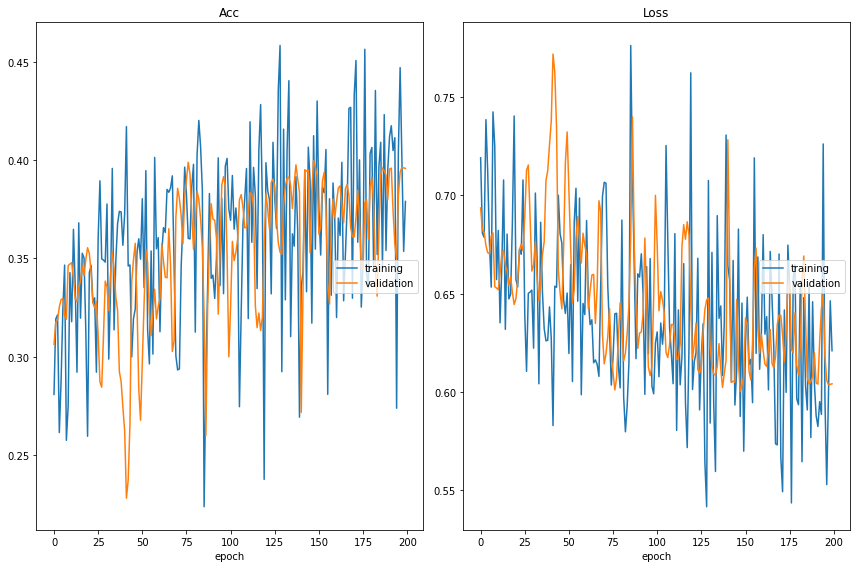

Acc
	training         	 (min:    0.224, max:    0.458, cur:    0.379)
	validation       	 (min:    0.228, max:    0.400, cur:    0.396)
Loss
	training         	 (min:    0.542, max:    0.776, cur:    0.621)
	validation       	 (min:    0.600, max:    0.772, cur:    0.604)
CPU times: user 23min 36s, sys: 5min 25s, total: 29min 2s
Wall time: 44min 24s


In [ ]:
%%time
#plotting in Jupyter Notebook
liveloss = PlotLosses()
#logs
logs = {}
#iterate epochs
for epoch in range(train_params['epochs_trained'] + 1, train_params['epochs'] + 1):
  #determine losses
  train_epoch_loss = 0
  val_epoch_loss = 0
  #specify training
  model.train()
  #iterate through the training data
  for i, (x, y_true) in enumerate(train_loader):
    #zero optimizers
    optimizer.zero_grad()
    #send to GPU
    x = x.to(device)
    y_true = y_true.to(device)
    #predict
    y_pred = model(x)
    #determine loss (should already be averaged)
    loss = criterion(y_pred, y_true)
    #backward
    loss.backward()
    #step
    optimizer.step()
    #track the loss
    train_epoch_loss = train_epoch_loss + loss.item() #/ train_params['batch_size']
    #break
    #if i > 1:
      #break
  #specify eval
  model.eval()
  #set
  #with torch.no_grad(): (doesn't work for some reason)
    #iterate through the testing data
  for i, (x, y_true) in enumerate(test_loader):
    #send to GPU
    x = x.to(device)
    y_true = y_true.to(device)
    #predict
    y_pred = model(x)
    #determine loss
    loss = criterion(y_pred, y_true)
    #track the loss (shoudld already be averaged)
    val_epoch_loss = val_epoch_loss + loss.item() #/ train_params['batch_size']
    #break
    #if i > 1:
      #break

  #calculate train
  train_loss = train_epoch_loss / len(train_loader)
  train_acc = 1 - train_loss
  
  #calulate loss
  val_loss = val_epoch_loss / len(test_loader)
  val_acc = 1 - val_loss

  #specify the logs
  prefix = ''
  logs['Loss'] = train_loss
  logs['Acc'] = train_acc 

  #record
  train_params['train_loss'] = train_loss
  train_params['train_acc'] = train_acc

  #logs
  prefix = 'val_'
  logs[prefix + 'Loss'] = val_loss 
  logs[prefix + 'Acc'] = val_acc

  #record
  train_params['val_loss'] = val_loss 
  train_params['val_acc'] = val_acc
  
  #living loss
  liveloss.update(logs)
  #send
  liveloss.send()
  #the scheduler (the way the loss is calculated must be correct for correct scheduling!)
  scheduler.step(train_epoch_loss)
  #scheduler.step()
  #save the model every 5 epochs 
  if (epoch % 5 == 0) and (epoch != 0):
    torch.save(model, train_params['save_path'] + 'model.pth')
    #keep track of training
    train_params['epochs_trained'] = 5 + train_params['epochs_trained']
    #save the number of epochs in case model stops training
    save_params(train_params, train_params['save_path'] + 'train_params.json')

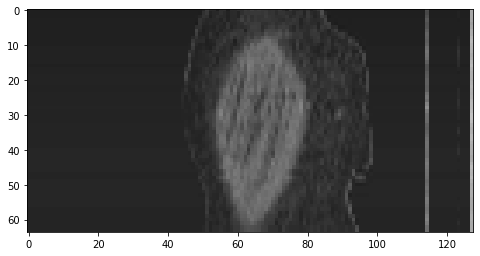

In [ ]:
#example of actual model input #save only the best or save after the run; definately could use a much better scheduler and run for longer number of epochs/ also increase depth! have the lr rates predefined?
CTViewer(np.squeeze(x.cpu().detach().numpy())[0]) #should I respace to 1, 1, 1 which will fix the spacing issue?
#overfitting, need larger diff between training and val?

In [ ]:
%%time
#load in a pretrained model
model = None
train_params, model = load_pretrained_model('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-ViT-AAA-results/3D-ViT-classification-2022-10-18-21-43/', device)
#read in the data file
df = pd.read_pickle(train_params['data_path'])

CPU times: user 1.5 s, sys: 1.37 s, total: 2.87 s
Wall time: 16.1 s


In [ ]:
%%time
#perform inference
model.eval()
df['Neg-Prob'], df['Pos-Prob'], df['Prediction'] = zip(*df.apply(perform_inference, axis = 1, args = ('Norm-CTA-128-128-64', model, device)))
#save
df.to_pickle(train_params['save_path'] + 'df_results.pkl')

CPU times: user 7.94 s, sys: 1.53 s, total: 9.46 s
Wall time: 3min 21s


In [ ]:
%%capture
#get the optimal thresholds for TRAIN and TEST
#the noiseiness of the learning is making this difficult!

#specify the threshold parameters
cutoffs = np.linspace(0.01, 0.99, 99) #cutoffs = np.linspace(0.01, 0.99, 9)
#need to see the optimal; probability thresholds for training vs testing

#get opt
df_train = get_opt(df, train_params, cutoffs, data = 'TRAIN')
#get opt
df_test = get_opt(df, train_params, cutoffs, data = 'TEST')

In [ ]:
#load previous files 
save_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-ViT-AAA-results/3D-ViT-classification-2022-10-18-21-43/'

#load params
train_params = load_params(save_path + 'train_params.json')
#read in the data file
df = pd.read_pickle(train_params['save_path'] + 'df_results.pkl')
#read in the data file train
df_train = pd.read_pickle(train_params['save_path'] + 'df_OPT_TRAIN.pkl')
#read in the data file test
df_test = pd.read_pickle(train_params['save_path'] + 'df_OPT_TEST.pkl')
#ap
df_ap = pd.read_pickle(train_params['save_path'] + 'df_results_ap.pkl')

In [ ]:
#get best based on train
best_train_cutoff = df_train.iloc[0]['Cutoff']
print('Train Set')
display(df_train.head(1)) #manually noted as the same!
#display
display(df_train[df_train['Cutoff'] == 0.5])
#display
print('Test Set')
display(df_test[df_test['Cutoff'] == best_train_cutoff])
#display
display(df_test[df_test['Cutoff'] == 0.5])
#update the df results file and save accordingly, then display the classification performance
df['OPT-Prediction'] = df.apply(opt_predictions, axis = 1, args = (best_train_cutoff, ))
#save
df.to_pickle(train_params['save_path'] + 'df_results.pkl')
#update train params
train_params['OPT'] = best_train_cutoff
#save
save_params(train_params, train_params['save_path'] + 'train_params.json')
#shall I apply the best cutoff of each

Train Set


,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
51,0.52,31,7,15,20,0.740741,0.673913,0.571429,0.815789,0.645161,0.69863


,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
49,0.5,28,10,13,22,0.6875,0.682927,0.628571,0.736842,0.656716,0.684932


Test Set


,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
51,0.52,17,8,7,18,0.692308,0.708333,0.72,0.68,0.705882,0.7


,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
49,0.5,17,8,7,18,0.692308,0.708333,0.72,0.68,0.705882,0.7


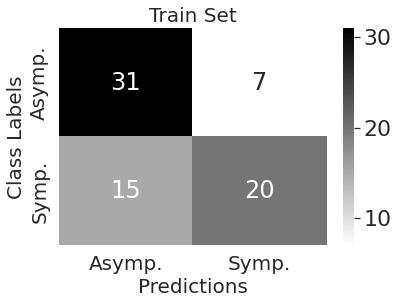

              precision    recall  f1-score   support

           0       0.67      0.82      0.74        38
           1       0.74      0.57      0.65        35

    accuracy                           0.70        73
   macro avg       0.71      0.69      0.69        73
weighted avg       0.71      0.70      0.69        73



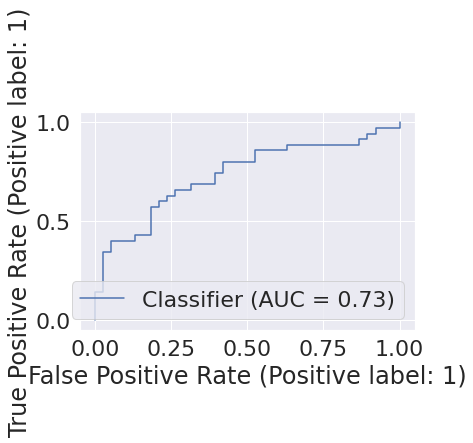

In [ ]:
pred_type = 'OPT-Prediction' # 'Prediction' for 0.5 'OPT-Prediction' as informed by training set

#train set performance
train_labels = df[df['DATA'] == 'TRAIN']['Class_Label'].to_list()
train_predictions = df[df['DATA'] == 'TRAIN'][pred_type].to_list()
train_pos_predictions = df[df['DATA'] == 'TRAIN']['Pos-Prob'].to_list()

#results
plot_confusion_matrix(train_labels, train_predictions, title = 'Train Set', ticks = ['Asymp.', 'Symp.'], 
                      train_params = train_params, pred_type = pred_type)

print(sklearn.metrics.classification_report(train_labels, train_predictions))
#print('ROC-AUC Curve: ', sklearn.metrics.roc_auc_score(train_labels, pos_predictions))
RocCurveDisplay.from_predictions(train_labels, train_pos_predictions)
plt.show()

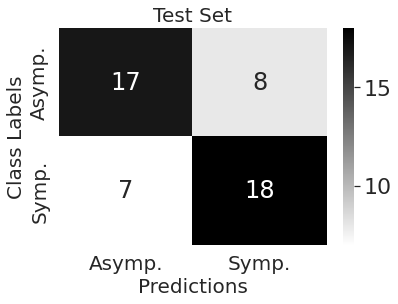

              precision    recall  f1-score   support

           0       0.71      0.68      0.69        25
           1       0.69      0.72      0.71        25

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.70      0.70      0.70        50



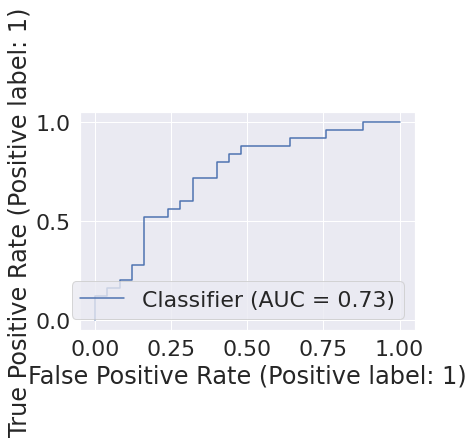

In [ ]:
#test set performance
test_labels = df[df['DATA'] == 'TEST']['Class_Label'].to_list()
test_predictions = df[df['DATA'] == 'TEST'][pred_type].to_list()
test_pos_predictions = df[df['DATA'] == 'TEST']['Pos-Prob'].to_list()

#results
plot_confusion_matrix(test_labels, test_predictions, title = 'Test Set', ticks = ['Asymp.', 'Symp.'], 
                      train_params = train_params, pred_type = pred_type)
print(sklearn.metrics.classification_report(test_labels, test_predictions))
#print('ROC-AUC Curve: ', sklearn.metrics.roc_auc_score(train_labels, pos_predictions))
RocCurveDisplay.from_predictions(test_labels, test_pos_predictions)
plt.show()

In [ ]:
#see if same
df_train.head(5)

,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
51,0.52,31,7,15,20,0.740741,0.673913,0.571429,0.815789,0.645161,0.698630
47,0.48,28,10,12,23,0.696970,0.700000,0.657143,0.736842,0.676471,0.698630
46,0.47,28,10,12,23,0.696970,0.700000,0.657143,0.736842,0.676471,0.698630
49,0.50,28,10,13,22,0.687500,0.682927,0.628571,0.736842,0.656716,0.684932
41,0.42,22,16,7,28,0.636364,0.758621,0.800000,0.578947,0.708861,0.684932


In [ ]:
#see if same use 0.52 or 0.50!!!
df_test.head(7)

,Cutoff,True Negative,False Positive,False Negative,True Positive,Precision,Negative Predictive Value,Recall,Specificity,F1,Accuracy
49,0.50,17,8,7,18,0.692308,0.708333,0.72,0.68,0.705882,0.70
40,0.41,13,12,3,22,0.647059,0.812500,0.88,0.52,0.745763,0.70
41,0.42,13,12,3,22,0.647059,0.812500,0.88,0.52,0.745763,0.70
48,0.49,17,8,7,18,0.692308,0.708333,0.72,0.68,0.705882,0.70
50,0.51,17,8,7,18,0.692308,0.708333,0.72,0.68,0.705882,0.70
51,0.52,17,8,7,18,0.692308,0.708333,0.72,0.68,0.705882,0.70
39,0.40,12,13,3,22,0.628571,0.800000,0.88,0.48,0.733333,0.68


In [ ]:
#see AP performance
df.groupby(['DATA', 'Class'])['Neg-AP'].describe().round(2)

count  mean   std   min   25%   50%   75%   max
DATA  Class                                                        
TEST  Asymptomatic   25.0  0.03  0.04  0.00  0.01  0.01  0.04  0.15
      Symptomatic    25.0  0.06  0.07  0.01  0.02  0.04  0.06  0.24
TRAIN Asymptomatic   38.0  0.03  0.05  0.00  0.01  0.01  0.02  0.29
      Symptomatic    35.0  0.07  0.10  0.01  0.02  0.03  0.09  0.42

In [ ]:
#see AP performance
df.groupby(['DATA', 'Class'])['Pos-AP'].describe().round(2)

count  mean   std   min   25%   50%   75%   max
DATA  Class                                                        
TEST  Asymptomatic   25.0  0.02  0.03  0.00  0.01  0.01  0.02  0.14
      Symptomatic    25.0  0.06  0.04  0.01  0.02  0.06  0.09  0.16
TRAIN Asymptomatic   38.0  0.02  0.03  0.00  0.01  0.01  0.02  0.13
      Symptomatic    35.0  0.06  0.07  0.00  0.01  0.04  0.08  0.27

In [ ]:
df_pos

,Class,Class_Label,Wall,Wall_Label,Patient,Norm-CTA,Mask-Wall,Mask-ILT,Mask-AAA,Mask-All,...,Mask-Cropped-All-128-128-64,DATA,Neg-Prob,Pos-Prob,Prediction,OPT-Prediction,neg-heatmap,pos-heatmap,Neg-AP,Pos-AP
88,Symptomatic,1,Unruptured,1,R028,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.087120,0.912880,1,1,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.033807,0.161146
95,Symptomatic,1,Unruptured,1,R039,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.041236,0.958764,1,1,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.024712,0.142180
79,Symptomatic,1,Unruptured,1,R013,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.320491,0.679509,1,1,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.052220,0.121924
94,Symptomatic,1,Unruptured,1,R038,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.253127,0.746873,1,1,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.043239,0.105868
93,Symptomatic,1,Unruptured,1,R035,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.038874,0.961126,1,1,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.238013,0.105540
63,Symptomatic,1,Ruptured,2,R018,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.562455,0.437545,0,0,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.012649,0.094390
99,Symptomatic,1,Unruptured,1,R062,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.149672,0.850328,1,1,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,0.045070,0.094019
102,Symptomatic,1,Unruptured,1,R068,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,...,/content/gdrive/MyDrive/AAA_Project/Masters-Th...,TEST,0.340627,0.659373,1,1,/content/gdrive/MyDrive/AAA_Project/Mas

In [ ]:
#does the index depend on order?

In [ ]:
#generate the probability and binary heatmaps
def get_heatmaps(row, attribution_generator, train_params, index, save_name, binary_thresh = None, binarize = False): #specify the class index!
  #init
  resampler = sitk.ResampleImageFilter()
  norm = sitk.RescaleIntensityImageFilter()
  norm.SetOutputMaximum(1)
  norm.SetOutputMinimum(0)

  #sitk image
  sitk_image = sitk.ReadImage(row[train_params['col_image']])
  #orig image
  orig_image = sitk.ReadImage(row['Norm-CTA'])
  #inference
  image = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(sitk_image), axis = (0, 1)))
  #the total number of patches
  transformer_attribution = attribution_generator.generate_LRP(image.cuda(), method="transformer_attribution", index = index).detach() #need to specify the index to get the class that was not predicted!
  #reshape
  transformer_attribution = transformer_attribution.reshape(1, 1,
                                                            int(train_params['model_params']['img_size'][0] / train_params['model_params']['patch_size'][0]),
                                                            int(train_params['model_params']['img_size'][1] / train_params['model_params']['patch_size'][1]),
                                                            int(train_params['model_params']['img_size'][2] / train_params['model_params']['patch_size'][2])
   
                                                       )
  
  #patch size #need to modify this as neccessary
  transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor = train_params['model_params']['patch_size'], mode='trilinear') 
  #reshape once more why? --> drop axis
  transformer_attribution = transformer_attribution.reshape(train_params['model_params']['img_size']).cuda().data.cpu().numpy()
  #prepare the heatmap for sitk resampling
  heatmap = sitk.GetImageFromArray(transformer_attribution)
  #save space?
  transformer_attribution = None
  #copy
  heatmap.CopyInformation(sitk_image)
  #resample
  resampler.SetReferenceImage(orig_image)
  resampler.SetTransform(sitk.Transform())
  resampler.SetInterpolator(sitk.sitkBSpline) #consumes a lot more RAM? use nearest neighbor instead? any difference? B spline is suppossed to be smoother(could bebtter for proababilities and images/ not labels)
  #resampler.SetInterpolator(sitk.sitkNearestNeighbor)
  heatmap = resampler.Execute(heatmap)
  heatmap.CopyInformation(orig_image)
  #normalize between 0 and 1
  heatmap = norm.Execute(heatmap) #need to norm?
  #binarize or otsu (binarize appears a little bit better)
  if binarize:
    binary = sitk.BinaryThresholdImageFilter()
    binary.SetUpperThreshold(binary_thresh)
    binary.SetInsideValue(0)
    binary.SetOutsideValue(1)
    binary_heatmap = binary.Execute(heatmap)
  else:
    otsu = sitk.OtsuThresholdImageFilter()
    otsu.SetOutsideValue(1)
    otsu.SetInsideValue(0)
    binary_heatmap = otsu.Execute(heatmap)
  

  #save stuff
  heatmap_path = save_image(train_params['save_path'], save_name, row['Patient'], heatmap)
  #bin_heatmap_path = save_image(train_params['save_path'], 'bin-heatmap', row['Patient'], binary_heatmap)
  heatmap = None
  #return
  return heatmap_path

In [ ]:
%%time 
#35 min
#df = df[df['DATA'] == 'TEST']
#get the heatmaps(need GPU!)
model.eval()
attribution_generator = LRP(model)
#apply heatmap for neg class asymtommatic cases!
df['neg-heatmap'] = df.apply(get_heatmaps, axis = 1, args = (attribution_generator, train_params, 0, 'neg-heatmap'))
#apply heatmap for pos class symtomatic cases!
df['pos-heatmap'] = df.apply(get_heatmaps, axis = 1, args = (attribution_generator, train_params, 1, 'pos-heatmap'))
#save
df.to_pickle(train_params['save_path'] + 'df_results_ap.pkl')

CPU times: user 42min 17s, sys: 23.1 s, total: 42min 40s
Wall time: 34min 9s


In [ ]:
#vectorize
def vectorize(row, col):
  attn_map = sitk.GetArrayFromImage(sitk.ReadImage(row[col])).flatten()
  return attn_map

#segmentation performance
def segmentation_performance_ap(row):
  #iterate 
  gt = vectorize(row, 'Mask-All')
  neg_map = vectorize(row, 'neg-heatmap')
  pos_map = vectorize(row, 'pos-heatmap')
  gt = np.where(gt >= 1, 1, 0)
  neg_score = sklearn.metrics.average_precision_score(gt, neg_map)
  pos_score = sklearn.metrics.average_precision_score(gt, pos_map)
  #return
  return neg_score, pos_score

In [ ]:
%%time 
#32 min
#determine AAA segmentation exclusiveity image wise and with labels (takes very long time --> come up with way for faster?)
df['Neg-AP'], df['Pos-AP'] = zip(*df.apply(segmentation_performance_ap, axis = 1))
#save
df.to_pickle(train_params['save_path'] + 'df_results.pkl')

CPU times: user 15min 44s, sys: 34.6 s, total: 16min 19s
Wall time: 24min 3s


In [ ]:
#subset
df_sub = df[df['DATA'] == 'TEST']
#select from the negative class
df_neg = df_sub[df_sub['Class'] == 'Asymptomatic']
#sort AP
df_neg = df_neg.sort_values(['Neg-AP'], ascending = False)

#select from the negative class
df_pos = df_sub[df_sub['Class'] == 'Symptomatic']
#sort AP
df_pos = df_pos.sort_values(['Pos-AP'], ascending = False)

In [ ]:
df.groupby(['DATA', 'Class'])['Neg-AP'].describe()

count      mean       std       min       25%       50%  \
DATA  Class                                                                   
TEST  Asymptomatic   25.0  0.028385  0.035209  0.003814  0.006234  0.013450   
      Symptomatic    25.0  0.064778  0.069063  0.005049  0.024712  0.043239   
TRAIN Asymptomatic   38.0  0.026297  0.048528  0.002716  0.007049  0.013888   
      Symptomatic    35.0  0.070961  0.100254  0.005919  0.018423  0.032916   

                         75%       max  
DATA  Class                             
TEST  Asymptomatic  0.035334  0.145114  
      Symptomatic   0.064943  0.239441  
TRAIN Asymptomatic  0.021721  0.293122  
      Symptomatic   0.087105  0.421332

In [ ]:
df_neg.iloc[0]

Class                                                               Asymptomatic
Class_Label                                                                    0
Wall                                                                          NA
Wall_Label                                                                     0
Patient                                                                     U105
Norm-CTA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall                      /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-All                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Norm-CTA-64                    /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall-64                   /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT-64                 

In [ ]:
df_pos.iloc[7]

Class                                                                Symptomatic
Class_Label                                                                    1
Wall                                                                  Unruptured
Wall_Label                                                                     1
Patient                                                                     R068
Norm-CTA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall                      /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-All                       /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Norm-CTA-64                    /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall-64                   /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT-64                 

In [ ]:
df_2D = pd.read_pickle('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/2D/data.pkl')

In [ ]:
df_temp = df_2D[df_2D['Patient'] == 'R035']

In [ ]:
def get_2D(row):
  return sitk.GetArrayFromImage(sitk.ReadImage(row['CT'])), row['CT_im']

In [ ]:
image, ls = zip(*df_temp.apply(get_2D, axis = 1))

In [ ]:
im = np.stack(image)
CTA_3D = sitk.GetImageFromArray(im)
#norm
z = sitk.NormalizeImageFilter()
CTA_3D = z.Execute(CTA_3D)

In [ ]:
sitk.WriteImage(CTA_3D, '/content/temp.nii.gz')

In [ ]:
ls

('IN000540',
 'IN000541',
 'IN000542',
 'IN000543',
 'IN000544',
 'IN000545',
 'IN000546',
 'IN000547',
 'IN000548',
 'IN000549',
 'IN000550',
 'IN000551',
 'IN000552',
 'IN000553',
 'IN000554',
 'IN000555',
 'IN000556',
 'IN000557',
 'IN000558',
 'IN000559',
 'IN000560',
 'IN000561',
 'IN000562',
 'IN000563',
 'IN000564',
 'IN000565',
 'IN000566',
 'IN000567',
 'IN000568',
 'IN000569',
 'IN000881',
 'IN000882',
 'IN000883',
 'IN000885',
 'IN000886',
 'IN000887',
 'IN000888',
 'IN000889',
 'IN000890',
 'IN000891',
 'IN000892',
 'IN000893',
 'IN000894',
 'IN000895',
 'IN000896',
 'IN000897',
 'IN000898',
 'IN000899',
 'IN000900',
 'IN000901',
 'IN000902',
 'IN000903',
 'IN000904',
 'IN000905',
 'IN000906',
 'IN000907',
 'IN000908',
 'IN000909',
 'IN000910',
 'IN000911',
 'IN000912',
 'IN000913',
 'IN000914',
 'IN000915',
 'IN000916',
 'IN000917',
 'IN000918',
 'IN000919',
 'IN000920',
 'IN000921',
 'IN000922',
 'IN000923',
 'IN000924',
 'IN000925',
 'IN000926',
 'IN000927',
 'IN000928',

count      mean       std       min       25%       50%  \
DATA  Class                                                                   
TEST  Asymptomatic   25.0  0.021985  0.030528  0.002078  0.005730  0.011076   
      Symptomatic    25.0  0.058841  0.044692  0.008653  0.015779  0.058567   
TRAIN Asymptomatic   38.0  0.023807  0.030712  0.001901  0.006809  0.008205   
      Symptomatic    35.0  0.062422  0.068112  0.004735  0.013672  0.037661   

                         75%       max  
DATA  Class                             
TEST  Asymptomatic  0.016946  0.140893  
      Symptomatic   0.094019  0.161146  
TRAIN Asymptomatic  0.024198  0.130664  
      Symptomatic   0.082628  0.272940

In [ ]:
df['Neg-AP'].describe()

count    123.000000
mean       0.047252
std        0.071633
min        0.002716
25%        0.009494
50%        0.021029
75%        0.047411
max        0.421332
Name: Neg-AP, dtype: float64

In [ ]:
df['Pos-AP'].describe()

count    123.000000
mean       0.041545
std        0.050179
min        0.001901
25%        0.007986
50%        0.016433
75%        0.061009
max        0.272940
Name: Pos-AP, dtype: float64

In [ ]:
#get only the test data
df_sub = df[df['DATA'] == 'TEST']
#correct
df_correct = df_sub.loc[(df_sub['Class_Label'] == df_sub['Prediction'])]
#wrong
df_wrong = df_sub.loc[(df_sub['Class_Label'] != df_sub['Prediction'])]

In [ ]:
df_correct['Class'].value_counts()

Symptomatic     18
Asymptomatic    17
Name: Class, dtype: int64

In [ ]:
#compare via custom metrics?
#get image
def get_image(row, col):
  return sitk.ReadImage(row[col])

def custom_metrics(row, prob = 0.5, binary = sitk.BinaryThresholdImageFilter(), metrics = sitk.LabelShapeStatisticsImageFilter()):
  #set up
  gt = get_image(row, 'Mask-All')
  neg_map = get_image(row, 'neg-heatmap')
  pos_map = get_image(row, 'pos-heatmap')
  #binarize
  binary.SetUpperThreshold(3)
  binary.SetLowerThreshold(1)
  gt = binary.Execute(gt)
  #get the thresholded
  binary.SetUpperThreshold(1)
  binary.SetLowerThreshold(prob)
  neg_map = binary.Execute(neg_map)
  pos_map = binary.Execute(pos_map)
  #add
  metrics.Execute(neg_map)
  neg_all = metrics.GetNumberOfPixels(1)
  metrics.Execute(pos_map)
  pos_all = metrics.GetNumberOfPixels(1)
  metrics.Execute(gt)
  gt_all = metrics.GetNumberOfPixels(1)
  #compare
  neg_image = sitk.Add(neg_map, gt)
  pos_image = sitk.Add(pos_map, gt)
  #counts
  metrics.Execute(neg_image)
  try:
    neg_tp = metrics.GetNumberOfPixels(2)
  else:
    neg_tp = 0
  neg_fp_fn = metrics.GetNumberOfPixels(1)
  metrics.Execute(pos_image)
  pos_tp = metrics.GetNumberOfPixels(2)
  pos_fp_fn = metrics.GetNumberOfPixels(1)
  #compute
  results = (neg_tp / gt_all), (pos_tp / gt_all) #, (neg_fp_fn / neg_all), (pos_fp_fn / pos_all)
  #return
  return results

In [ ]:
#df['Neg-True'], df['Pos-True'], df['Neg-False'], df['Pos-False'] = zip(*df.apply(custom_metrics, axis = 1))
df['Neg-Overlap'], df['Pos-Overlap'] = zip(*df.apply(custom_metrics, axis = 1))

RuntimeError: ignored

In [ ]:
#init
binary = sitk.BinaryThresholdImageFilter()
metrics = sitk.LabelShapeStatisticsImageFilter()
prob = 0.5
row = df.iloc[10]

#set up
gt = get_image(row, 'Mask-All')
neg_map = get_image(row, 'neg-heatmap')
pos_map = get_image(row, 'pos-heatmap')
#binarize
binary.SetUpperThreshold(3)
binary.SetLowerThreshold(1)
gt = binary.Execute(gt)
#get the thresholded
binary.SetUpperThreshold(1)
binary.SetLowerThreshold(prob)
neg_map = binary.Execute(neg_map)
pos_map = binary.Execute(pos_map)
#add
metrics.Execute(neg_map)
neg_all = metrics.GetNumberOfPixels(1)
metrics.Execute(pos_map)
pos_all = metrics.GetNumberOfPixels(1)
metrics.Execute(gt)
gt_all = metrics.GetNumberOfPixels(1)
#compare
neg_image = sitk.Add(neg_map, gt)
pos_image = sitk.Add(pos_map, gt)
#counts
metrics.Execute(neg_image)
neg_tp = metrics.GetNumberofPixels(2)
neg_fp_fn = metrics.GetNumberOfPixels(1)
metrics.Execute(pos_image)
pos_tp = metrics.GetNumberofPixels(2)
pos_fp_fn = metrics.GetNumberOfPixels(1)
#compute
results = ((neg_tp / gt_all), (pos_tp / gt_all), (neg_fp_fn / neg_all), (pos_fp_fn / pos_all))



In [ ]:
def get_metrics2(train_params, df, thresholds):
  for threshold in thresholds:
    #tag
    tag = '-' + str(threshold)
    df['neg-DSC' + tag], df['neg-FP' + tag], df['neg-FN' + tag], df['pos-DSC' + tag], df['pos-FP' + tag], df['pos-FN' + tag] = zip(*df.apply(get_dice, 
                                                                                                                                             axis = 1, 
                                                                                                                                             args = (threshold, )))
  #save
  df.to_pickle(train_params['save_path'] + 'df_results_seg.pkl')
  #return df
  return df
def get_dice(row, prob, binary = sitk.BinaryThresholdImageFilter(), metrics = sitk.LabelOverlapMeasuresImageFilter()):
  #binarize the gt image
  gt = sitk.ReadImage(row['Mask-All'])
  binary.SetUpperThreshold(3)
  binary.SetLowerThreshold(1)
  gt = binary.Execute(gt)
  #maps binarize
  neg_map = sitk.ReadImage(row['neg-heatmap'])
  pos_map = sitk.ReadImage(row['pos-heatmap'])
  binary.SetUpperThreshold(1)
  binary.SetLowerThreshold(prob)
  neg_map = binary.Execute(neg_map)
  pos_map = binary.Execute(pos_map)
  #compare negative
  metrics.Execute(gt, neg_map)
  neg_DSC = metrics.GetDiceCoefficient()
  neg_FP = metrics.GetFalsePositiveError()
  neg_FN = metrics.GetFalseNegativeError()
  #compare positive
  metrics.Execute(gt, pos_map)
  pos_DSC = metrics.GetDiceCoefficient()
  pos_FP = metrics.GetFalsePositiveError()
  pos_FN = metrics.GetFalseNegativeError()
  #return
  return neg_DSC, neg_FP, neg_FN, pos_DSC, pos_FP, pos_FN

In [ ]:
%%time
#instead of this could use a variable threshold 18 min?
thresholds = np.around(np.linspace(0.05, 0.95, 19), 2) #this takes forever
df = get_metrics2(train_params = train_params, df = df, thresholds = thresholds)